In [1]:
import datetime
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def destagger(var, stagger_dim):
    '''
    From wrf-python 
    https://github.com/NCAR/wrf-python/blob/b40d1d6e2d4aea3dd2dda03aae18e268b1e9291e/src/wrf/destag.py 
    '''
    var_shape = var.shape
    num_dims = var.ndim
    stagger_dim_size = var_shape[stagger_dim]

    full_slice = slice(None)
    slice1 = slice(0, stagger_dim_size - 1, 1)
    slice2 = slice(1, stagger_dim_size, 1)

    dim_ranges_1 = [full_slice] * num_dims
    dim_ranges_2 = [full_slice] * num_dims

    dim_ranges_1[stagger_dim] = slice1
    dim_ranges_2[stagger_dim] = slice2

    result = .5*(var[tuple(dim_ranges_1)] + var[tuple(dim_ranges_2)])

    return result

def find_lat_lon_idx(lons, lats, lon, lat):
    '''
    Finds the index of the latitude and longitude closest to inputted values
    
    Returns tuple with indexes: (lat, lon)
    '''
    # conversions
    km_lon = 85
    km_lat = 111

    # Find the closest model grid cell to the lidar (or whatever location you're interested in)
    dist = np.sqrt(np.square(abs(km_lon*(lons-lon)))
                  + np.square(abs(km_lat*(lats-lat))))
    loc = np.where(dist==np.min(dist))
    
    return int(loc[0]), int(loc[1])

### read in a file

In [3]:
# file_name = "/pl/active/WRFLES_GAD/N_Atl/reruns_Beiter/wrfouts/vw_100_tke/2019/09/wrfout_d02_2019-09-07_09:00:00"
# file_name = "/pl/active/WRFLES_GAD/N_Atl/reruns_Beiter/wrfouts/vw_100_tke/2019/12/wrfout_d02_2019-12-02_10:00:00"
file_name = "/pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/vw_100_tke/2019/12/wrfout_d02_2019-12-31_05:00:00"

In [4]:
nwf_ds = xr.open_dataset(file_name)

In [39]:
# domain - side quest
print(f'Latitude bounds: {ds.XLAT.min().values:.5f} - {ds.XLAT.max().values:.5f}')
print(f'Longitude bounds: {ds.XLONG.min().values:.5f} - {ds.XLONG.max().values:.5f}')

Latitude bounds: 37.38948 - 42.13687
Longitude bounds: -76.20822 - -64.97662


### process data

In [5]:
# Read in latitude, longitude, time, height, and winds
nwf_lats   = nwf_ds['XLAT'] 
nwf_lons   = nwf_ds['XLONG']  
nwf_times  = nwf_ds['XTIME']  
nwf_U      = nwf_ds['U']      
nwf_V      = nwf_ds['V']

# Destagger, then find wind speeds
nwf_U = destagger(nwf_ds['U'], 3)
nwf_U = nwf_U.rename({'west_east_stag': 'west_east'})
nwf_V = destagger(nwf_ds['V'], 2)
nwf_V = nwf_V.rename({'south_north_stag': 'south_north'})
nwf_wspd = np.sqrt((nwf_U**2)+(nwf_V**2))

# Select location: VW centroid 40.95N, -70.59E

# Select lat/lon values
lon_vals = nwf_lons.sel(Time=0)
lat_vals = nwf_lats.sel(Time=0)

# Find index of lat lon values 
lon_idx = find_lat_lon_idx(lon_vals, lat_vals, lon=-70.59, lat=40.95)[1]
lat_idx = find_lat_lon_idx(lon_vals, lat_vals, lon=-70.59, lat=40.95)[0]

# Find actual lat/lon values
lon_val = float(lon_vals.sel(west_east=lon_idx, south_north=lat_idx).values)
lat_val = float(lat_vals.sel(west_east=lon_idx, south_north=lat_idx).values)

# Select this location in wspd data
nwf_wspd = nwf_wspd.sel(south_north=lat_idx, west_east=lon_idx)

# Calculate heights

# no wind farm
nwf_PH = destagger(nwf_ds['PH'], 1)
nwf_PH = nwf_PH.rename({'bottom_top_stag': 'bottom_top'})
nwf_PH = nwf_PH.sel(south_north=lat_idx, west_east=lon_idx)

nwf_PHB = destagger(nwf_ds['PHB'], 1)
nwf_PHB = nwf_PHB.rename({'bottom_top_stag': 'bottom_top'})
nwf_PHB = nwf_PHB.sel(south_north=lat_idx, west_east=lon_idx)

nwf_HGT = nwf_ds.HGT.sel(south_north=lat_idx, west_east=lon_idx)
nwf_z = np.array((nwf_PH+nwf_PHB)/9.81-nwf_HGT)

### Make plot

In [6]:
llj_data = pd.read_csv('../LLJ_data/VW100_vwcent.csv')

In [13]:
llj_data.iloc[2909]['Nose windspeed (m/s)']

28.14691162109375

In [14]:
llj_data.iloc[2909]['Nose height (meters)']

469.3748474121094

In [28]:
nwf_z[:, 26]

array([469.37485], dtype=float32)

In [77]:
min_ws_height

array([18599.98], dtype=float32)

In [7]:
nose_ws = nwf_wspd.sel(bottom_top=slice(0, 34)).max()
nose_height = nwf_z[:, 26]
min_ws = nwf_wspd.sel(bottom_top=slice(26, 34)).min()
min_ws_height = nwf_z[:, 26+5]

In [80]:
nwf_wspd.sel(bottom_top=slice(26, 34)).argmin()

<xarray.DataArray ()>
array(5)

In [8]:
nwf_z.shape

(1, 53)

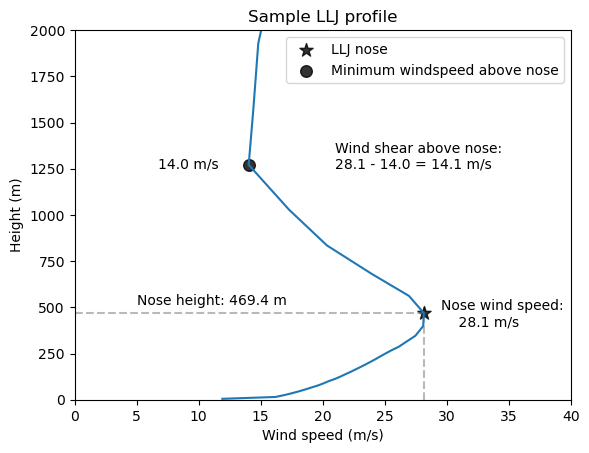

In [11]:
plt.figure()

plt.plot(nwf_wspd.sel(Time=0), nwf_z[0])
plt.scatter(nose_ws, nose_height, label='LLJ nose', marker='*', alpha=0.8, s=100, color='k')
plt.scatter(min_ws, min_ws_height, label='Minimum windspeed above nose', marker='o', alpha=0.8, s=70, color='k')
plt.axvline(nose_ws, linestyle='--', color='grey', alpha=0.55, ymax=0.25, zorder=0)
plt.axhline(nose_height, linestyle='--', color='grey', alpha=0.55, xmax=0.7)

plt.ylim(0, 2000)
plt.xlim(0, 40)
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Height (m)")
plt.title("Sample LLJ profile")
plt.text(29.5, 400, f'Nose wind speed:\n    {nose_ws.values:.1f} m/s')
plt.text(5, 515, f'Nose height: {nose_height[0]:.1f} m')
plt.text(6.7, 1250, f'{min_ws.values:.1f} m/s')
plt.text(21, 1250, f'Wind shear above nose:\n{nose_ws.values:.1f} - {min_ws.values:.1f} = {nose_ws.values-min_ws.values:.1f} m/s')
plt.legend();

#plt.savefig('../output_plots/sample_profile.png')

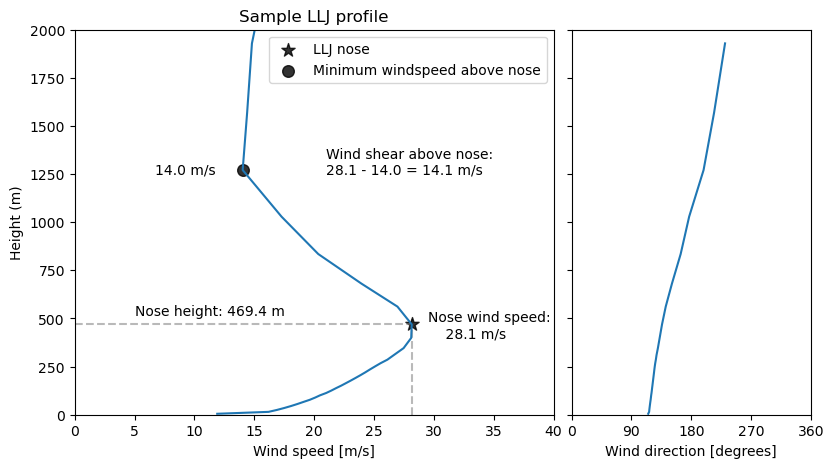

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9.5, 5), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)
ax0 = axs[0]
ax1 = axs[1]

ax0.plot(nwf_wspd.sel(Time=0), nwf_z[0])
ax0.scatter(nose_ws, nose_height, label='LLJ nose', marker='*', alpha=0.8, s=100, color='k')
ax0.scatter(min_ws, min_ws_height, label='Minimum windspeed above nose', marker='o', alpha=0.8, s=70, color='k')
ax0.axvline(nose_ws, linestyle='--', color='grey', alpha=0.55, ymax=0.25, zorder=0)
ax0.axhline(nose_height, linestyle='--', color='grey', alpha=0.55, xmax=0.7)

ax0.set_ylim(0, 2000)
ax0.set_xlim(0, 40)
ax0.set_xlabel("Wind speed [m/s]")
ax0.set_ylabel("Height (m)")
ax0.set_title("Sample LLJ profile")
ax0.text(29.5, 400, f'Nose wind speed:\n    {nose_ws.values:.1f} m/s')
ax0.text(5, 515, f'Nose height: {nose_height[0]:.1f} m')
ax0.text(6.7, 1250, f'{min_ws.values:.1f} m/s')
ax0.text(21, 1250, f'Wind shear above nose:\n{nose_ws.values:.1f} - {min_ws.values:.1f} = {nose_ws.values-min_ws.values:.1f} m/s')
ax0.legend();

ax1.plot(wdir.magnitude[0], nwf_z[0][:34])
ax1.set_xlim(0, 360)
ax1.set_xlabel("Wind direction [degrees]")
ax1.set_xticks([0, 90, 180, 270, 360])

plt.subplots_adjust(wspace=0.05, hspace=0)

plt.savefig('../output_plots/sample_profile_panel.png')

In [17]:
import metpy.calc as mpcalc
from metpy.units import units

In [18]:
U = nwf_U.sel(south_north=lat_idx, west_east=lon_idx, bottom_top=slice(0, 34))
V = nwf_V.sel(south_north=lat_idx, west_east=lon_idx, bottom_top=slice(0, 34))

wdir = mpcalc.wind_direction(U.values*units('m/s'), V.values*units('m/s'))

In [23]:
len(nwf_z[0])

53

In [28]:
wdir.magnitude[0]

array([115.18913 , 116.57317 , 116.86088 , 117.19344 , 117.56405 ,
       117.967255, 118.37863 , 118.84396 , 119.257904, 119.651115,
       120.16501 , 120.61202 , 121.02912 , 121.50723 , 121.97069 ,
       122.44272 , 122.92722 , 123.43123 , 123.93831 , 124.46194 ,
       125.06021 , 125.74261 , 126.68475 , 127.69562 , 129.75024 ,
       132.41956 , 135.97652 , 141.53615 , 150.89401 , 163.98431 ,
       176.75061 , 198.43706 , 214.23938 , 230.702   ], dtype=float32)

### Another sample

In [115]:
file_name = "/pl/active/WRFLES_GAD/N_Atl/reruns_Beiter/wrfouts/vw_100_tke/2019/12/wrfout_d02_2019-12-31_06:00:00"
nwf_ds = xr.open_dataset(file_name)

In [116]:
# Read in latitude, longitude, time, height, and winds
nwf_lats   = nwf_ds['XLAT'] 
nwf_lons   = nwf_ds['XLONG']  
nwf_times  = nwf_ds['XTIME']  
nwf_U      = nwf_ds['U']      
nwf_V      = nwf_ds['V']

# Destagger, then find wind speeds
nwf_U = destagger(nwf_ds['U'], 3)
nwf_U = nwf_U.rename({'west_east_stag': 'west_east'})
nwf_V = destagger(nwf_ds['V'], 2)
nwf_V = nwf_V.rename({'south_north_stag': 'south_north'})
nwf_wspd = np.sqrt((nwf_U**2)+(nwf_V**2))

# Select location: VW centroid 40.95N, -70.59E

# Select lat/lon values
lon_vals = nwf_lons.sel(Time=0)
lat_vals = nwf_lats.sel(Time=0)

# Find index of lat lon values 
lon_idx = find_lat_lon_idx(lon_vals, lat_vals, lon=-70.59, lat=40.95)[1]
lat_idx = find_lat_lon_idx(lon_vals, lat_vals, lon=-70.59, lat=40.95)[0]

# Find actual lat/lon values
lon_val = float(lon_vals.sel(west_east=lon_idx, south_north=lat_idx).values)
lat_val = float(lat_vals.sel(west_east=lon_idx, south_north=lat_idx).values)

# Select this location in wspd data
nwf_wspd = nwf_wspd.sel(south_north=lat_idx, west_east=lon_idx)

# Calculate heights

# no wind farm
nwf_PH = destagger(nwf_ds['PH'], 1)
nwf_PH = nwf_PH.rename({'bottom_top_stag': 'bottom_top'})
nwf_PH = nwf_PH.sel(south_north=lat_idx, west_east=lon_idx)

nwf_PHB = destagger(nwf_ds['PHB'], 1)
nwf_PHB = nwf_PHB.rename({'bottom_top_stag': 'bottom_top'})
nwf_PHB = nwf_PHB.sel(south_north=lat_idx, west_east=lon_idx)

nwf_HGT = nwf_ds.HGT.sel(south_north=lat_idx, west_east=lon_idx)
nwf_z = np.array((nwf_PH+nwf_PHB)/9.81-nwf_HGT)

In [121]:
nose_ws = nwf_wspd.sel(bottom_top=slice(0, 34)).max()
nose_height = nwf_z[:, nwf_wspd.sel(bottom_top=slice(0, 34)).argmax()]
min_ws = nwf_wspd.sel(bottom_top=slice(nwf_wspd.sel(bottom_top=slice(0, 34)).argmax().values, 34)).min()
min_ws_height = nwf_z[:, nwf_wspd.sel(bottom_top=slice(0, 34)).argmax().values+nwf_wspd.sel(bottom_top=slice(nwf_wspd.sel(bottom_top=slice(0, 34)).argmax().values, 34)).argmin()]

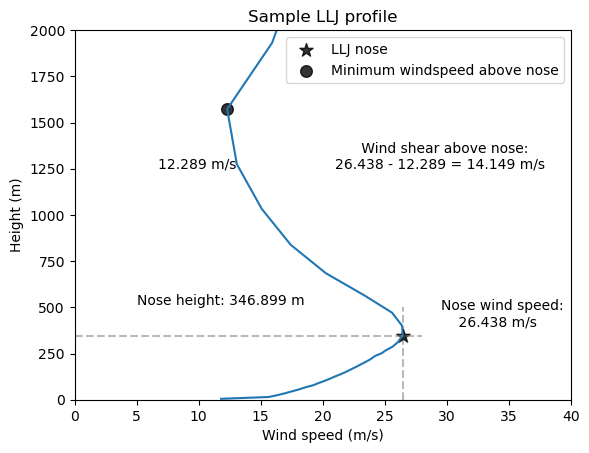

In [126]:
plt.figure()

plt.plot(nwf_wspd.sel(Time=0), nwf_z[0])
plt.scatter(nose_ws, nose_height, label='LLJ nose', marker='*', alpha=0.8, s=100, color='k')
plt.scatter(min_ws, min_ws_height, label='Minimum windspeed above nose', marker='o', alpha=0.8, s=70, color='k')
plt.axvline(nose_ws, linestyle='--', color='grey', alpha=0.55, ymax=0.25, zorder=0)
plt.axhline(nose_height, linestyle='--', color='grey', alpha=0.55, xmax=0.7)

plt.ylim(0, 2000)
plt.xlim(0, 40)
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Height (m)")
plt.title("Sample LLJ profile")
plt.text(29.5, 400, f'Nose wind speed:\n    {nose_ws.values:.3f} m/s')
plt.text(5, 515, f'Nose height: {nose_height[0]:.3f} m')
plt.text(6.7, 1250, f'{min_ws.values:.3f} m/s')
plt.text(21, 1250, f'      Wind shear above nose:\n{nose_ws.values:.3f} - {min_ws.values:.3f} = {nose_ws.values-min_ws.values:.3f} m/s')
plt.legend();

In [129]:
llj_data[2900:2920]

,Time,LLJ-classification,Nose windspeed (m/s),Nose height (meters),Rotor region shear (m/s),Rotor region shear (1/s),Rotor region veer (degrees),Rotor region veer (degrees/m),Surface to nose shear (m/s),Surface to nose shear (1/s),...,Surface to nose veer (degrees/m),Nose to min windspeed above nose shear (m/s),Nose to min windspeed above nose shear (1/s),Nose to min windspeed above nose veer (degrees),Nose to min windspeed above nose veer (degrees/m),Surface to top of rotor shear (m/s),Surface to top of rotor shear (1/s),Surface to top of rotor veer (degrees),Surface to top of rotor veer (degrees/m),Wind direction at nose (degrees)
2900,2019-12-30 20:00:00,2.0,22.963343,457.783722,2.678772,0.012646,0.743797,0.003511,6.860905,0.015148,...,0.005187,8.043284,0.014931,30.0,0.055689,6.353167,0.026357,1.010666,0.004193,94.203028
2901,2019-12-30 21:00:00,1.0,22.749424,458.168854,2.811609,0.013261,0.989252,0.004666,6.844259,0.015099,...,0.005178,7.010678,0.012987,29.0,0.053723,6.336414,0.026265,1.055749,0.004376,97.851538
2902,2019-12-30 22:00:00,2.0,23.454155,458.581879,3.188457,0.015025,1.177522,0.005549,7.543440,0.016626,...,0.006554,8.168720,0.015082,31.0,0.057234,6.847830,0.028360,1.323481,0.005481,100.299927
2903,2019-12-30 23:00:00,2.0,24.606977,548.727417,4.287556,0.020180,1.612784,0.007591,9.208576,0.016932,...,0.008562,8.537052,0.018793,32.0,0.070444,7.744593,0.032036,1.934163,0.008001,105.808778
2904,2019-12-31 00:00:00,1.0,24.387739,550.087646,4.452600,0.020908,2.532417,0.011891,9.615833,0.017637,...,0.012433,7.697470,0.016903,32.0,0.070268,7.784187,0.032125,2.972290,0.012267,108.070510
2905,2019-12-31 01:00:00,1.0,25.110308,551.458984,5.605434,0.026263,3.816391,0.017881,11.005030,0.020135,...,0.018363,7.312067,0.016009,31.0,0.067873,8.807085,0.036268,4.509131,0.018569,111.250925
2906,2019-12-31 02:00:00,1.0,27.687395,553.281189,5.253155,0.024544,4.278769,0.019992,14.515111,0.026469,...,0.025426,7.213116,0.015735,29.0,0.063260,11.405890,0.046843,5.697859,0.023400,118.239627
2907,2019-12-31 03:00:00,1.0,29.208727,555.624207,6.423235,0.029893,3.838772,0.017865,15.854996,0.028790,...,0.021547,7.827364,0.016972,34.0,0.073724,12.374361,0.050624,3.095770,0.012665,124.454626
2908,2019-12-31 04:00:00,3.0,30.361998,466.976837,7.017981,0.032528,4.585619,0.021254,15.963956,0.034551,...,0.027755,11.097937,0.019902,47.0,0.084284,13.318194,0.054271,4.739585,0.019314,129.548393
2909,2019-12-31 05:00:00,3.0,28.422043,399.160309,7.612940,0.035118,8.292434,0.038252,15.181726,0.038511,...,0.042918,11.477886,0.018186,51.0,0.080806,13.662978,0.055423,9.207380,0.037349,134.248577
